<a href="https://colab.research.google.com/github/hessamhz/dasa/blob/main/sential2dataanalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import ee
import geemap
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from google.colab import auth
auth.authenticate_user(project_id='wotr-443814')

In [ ]:
# Initialize the Earth Engine API
ee.Initialize()

In [ ]:
# Define the boundary for Amaravati, Maharashtra, India
boundary = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level2') \
    .filter(ee.Filter.And(
        ee.Filter.eq('ADM1_NAME', 'Maharashtra'),  # State filter
        ee.Filter.eq('ADM2_NAME', 'Amravati')     # District filter
    ))

In [ ]:
# Load Sentinel-2 Surface Reflectance Data
s2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
    .filterDate('2022-01-01', '2022-12-31') \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
    .map(lambda image: image.updateMask(image.select('QA60').bitwiseAnd(1 << 10).eq(0))) \
    .select(['B2', 'B3', 'B4', 'B8', 'B11', 'B12'])  # Useful bands for indices

In [ ]:
# Functions to compute various indices
def add_ndvi(image):
    return image.addBands(image.normalizedDifference(['B8', 'B4']).rename('NDVI'))  # NIR, Red

def add_ndwi(image):
    return image.addBands(image.normalizedDifference(['B8', 'B11']).rename('NDWI'))  # NIR, SWIR1

def add_ndmi(image):
    return image.addBands(image.normalizedDifference(['B8', 'B11']).rename('NDMI'))  # NIR, SWIR1

def add_gi(image):
    return image.addBands(image.select('B3').divide(image.select('B2')).rename('GI'))  # Green/Blue

def add_gcvi(image):
    return image.addBands(image.select('B8').divide(image.select('B3')).subtract(1).rename('GCVI'))  # (NIR / Green) - 1

In [ ]:
# Apply functions over the image collection and create a composite
indices_collection = s2 \
    .map(add_ndvi) \
    .map(add_ndwi) \
    .map(add_ndmi) \
    .map(add_gi) \
    .map(add_gcvi)

indices_composite = indices_collection.median().clip(boundary)

In [ ]:
indices_composite = indices_collection.median().clip(boundary)

# Visualization parameters for indices
viz_params = {
    'NDVI': {'min': 0, 'max': 1, 'palette': ['red', 'yellow', 'green']},
    'NDWI': {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']},
    'NDMI': {'min': -1, 'max': 1, 'palette': ['brown', 'white', 'green']},
    'GI': {'min': 0, 'max': 2, 'palette': ['yellow', 'green']},
    'GCVI': {'min': 0, 'max': 10, 'palette': ['purple', 'yellow', 'green']}
}

In [ ]:
# Function to create and display maps dynamically
def create_map(index_name, viz_params, composite_image, boundary):
    map_obj = geemap.Map()
    map_obj.centerObject(boundary, 9)
    map_obj.addLayer(composite_image.select(index_name), viz_params, index_name)
    map_obj.addLayerControl()
    return map_obj

In [ ]:
# Generate and display maps for all indices in a single step
maps = {}
for index in ['NDVI', 'NDWI', 'NDMI', 'GI', 'GCVI']:
    maps[index] = create_map(index, viz_params[index], indices_composite, boundary)

# Display the map for each index
for map_obj in maps.values():
    display(map_obj)


Map(center=[21.189385699881374, 77.5694143557939], controls=(WidgetControl(options=['position', 'transparent_b…

Map(center=[21.189385699881374, 77.5694143557939], controls=(WidgetControl(options=['position', 'transparent_b…

Map(center=[21.189385699881374, 77.5694143557939], controls=(WidgetControl(options=['position', 'transparent_b…

Map(center=[21.189385699881374, 77.5694143557939], controls=(WidgetControl(options=['position', 'transparent_b…

Map(center=[21.189385699881374, 77.5694143557939], controls=(WidgetControl(options=['position', 'transparent_b…

In [ ]:
# # Calculate the mean of each band for the region (boundary)
bands_of_interest = ['GCVI', 'GI', 'NDMI', 'NDVI', 'NDWI']
# statistics = indices_composite.select(bands_of_interest).reduceRegion(
#     reducer=ee.Reducer.mean(),  # Calculate mean values
#     geometry=boundary.geometry(),  # Geometry of your boundary
#     scale=30,  # Resolution of the data (in meters)
#     maxPixels=1e8  # Maximum number of pixels
# )

# # Print the statistics for each band of interest
# print(statistics.getInfo())
statistics = indices_composite.select(bands_of_interest).reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=boundary.geometry(),
    scale=1000,  # Lower resolution for less memory usage (in meters)
    maxPixels=1e8
)


In [ ]:
# Print the statistics for each band of interest
print(statistics.getInfo())

{'GCVI': 1.7844614035428241, 'GI': 1.4051391722209738, 'NDMI': -0.015578260155226153, 'NDVI': 0.396126300121454, 'NDWI': -0.015578260155226153}


In [ ]:
# Function to get histogram for a sampled region
def get_histogram(image, index_name, region):
    sampled_image = image.select(index_name).sample(region=region, scale=1000, numPixels=5000)
    values = sampled_image.aggregate_array(index_name).getInfo()
    return np.array(values)

In [ ]:
# Generate histograms for each index
region = boundary
index_histograms = {}
for index in ['NDVI', 'NDWI', 'NDMI', 'GI', 'GCVI']:
    index_histograms[index] = get_histogram(indices_composite, index, region)

In [ ]:
# Plot histograms with a color gradient
def plot_histogram(values, title, color_map='plasma'):
    plt.figure(figsize=(10, 6))
    n, bins, patches = plt.hist(values, bins=50, color='yellow', edgecolor='black', alpha=0.7)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    for c, p in zip(plt.cm.plasma(np.linspace(0, 1, len(bins)-1)), patches):
        p.set_facecolor(c)
    plt.title(title)
    plt.xlabel('Index Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

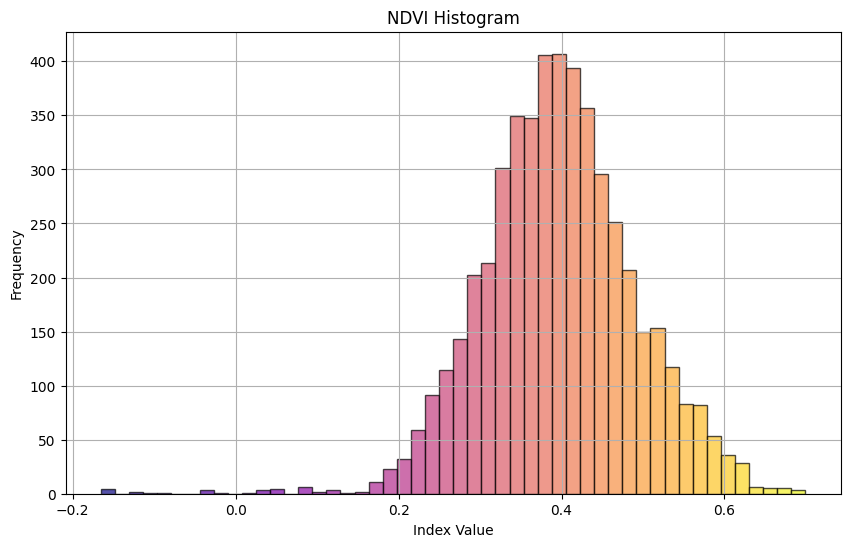

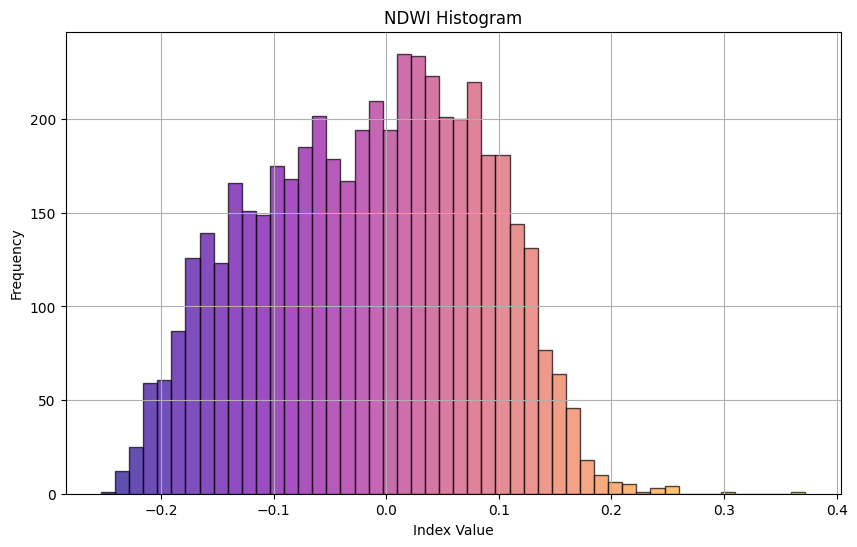

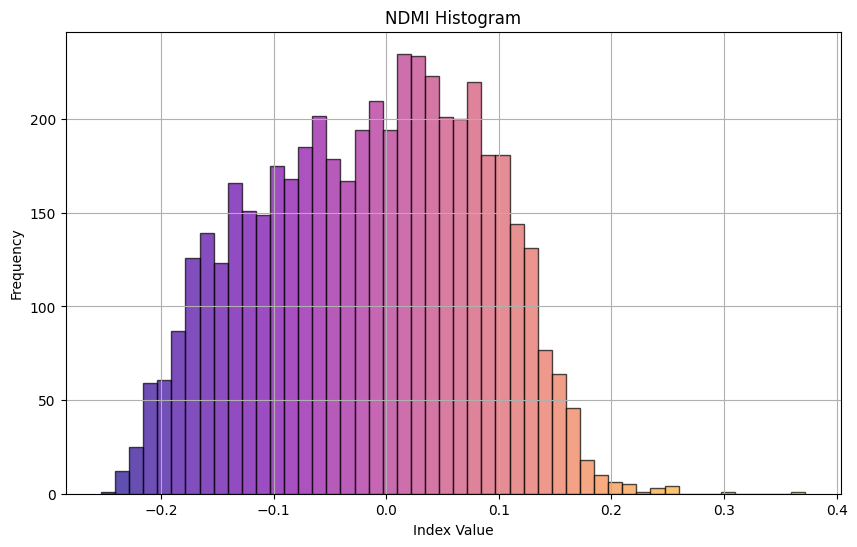

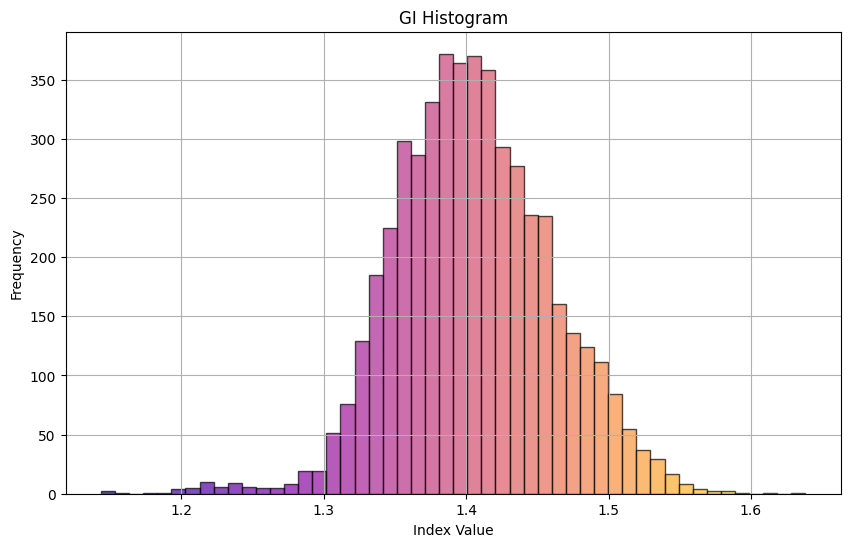

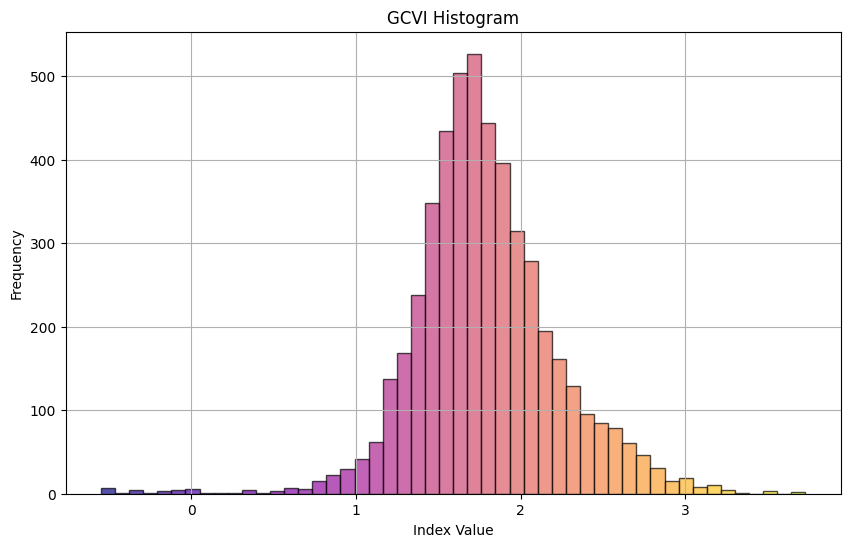

In [ ]:
# Plot each index histogram
for index, values in index_histograms.items():
    plot_histogram(values, f'{index} Histogram', color_map='plasma')